In [1]:
import torch
import torch.nn as nn
import numpy as np
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader


In [2]:
# Data Collection
import pandas as pd
import os 
data_file = os.path.join('.', 'data', 'spacenews_preprocessed.csv')

data_df = pd.read_csv(data_file)

# Adding random sentiments to data_df
import random
data_df['sentiment'] = [random.randint(-1, 1) for i in range(len(data_df))]

# Filtering data_df only for sentiment analysis

data_req_df = data_df[['summary', 'sentiment']].dropna()
data_req_df.head()

,summary,sentiment
0,cash-strapped smallsat operator astrocast anno...,-1
1,sierra space announced may 31 strategic partne...,0
2,long march 5b rocket arrived wenchang spacepor...,0
3,appears tit-for-tat move quad nations launch s...,0
4,members house science committee used hearing p...,1


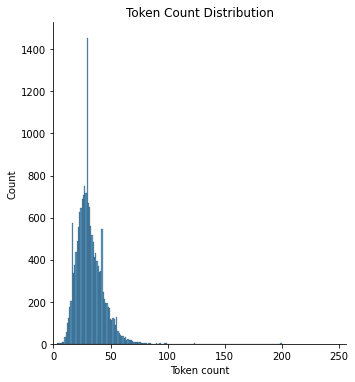

In [3]:
# Data pre-processing
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')



In [ ]:
# Analysing data for maximum token length
token_lens = []
for txt in data_req_df['summary']:
  tokens = tokenizer.encode(txt, max_length=200, truncation=True)
  token_lens.append(len(tokens))

sns.displot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.title('Token Count Distribution')
plt.show()


In [4]:
# Designing custom dataset and dataloader class
class CustomDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        )
        return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(reviews=df['summary'].to_numpy(), targets=df.sentiment.to_numpy(),
                    tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

In [5]:
# Train-Test-Evaluation Split
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

df_train, df_test = train_test_split(data_req_df,test_size=0.1,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [6]:
# Using CustomDataset class to create model compatible data
BATCH_SIZE = 1
MAX_LEN = 60
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [7]:
# Sample data from dataloader
data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel,self).__init__()
        # BERT Encoder Layer
        self.bert = BertModel.from_pretrained('bert-base-cased')
        
        # Decoder Layers for Sentiment Classifier
        self.sc_drop = nn.Dropout(0.3)
        self.sc_out = nn.Linear(self.bert.config.hidden_size, 3)

        # Decoder Layers for Summarization
        

    def forward(self, input_ids, attention_mask):
        # BERT Encoder
        bert_output = self.bert(input_ids= input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = bert_output["pooler_output"]
        
        # Decoder for Sentiment Classifier
        sc_output = self.sc_drop(pooled_output)
        sc_output = self.sc_out(sc_output)

        # Decoder for Text Summarization
        

        return [sc_output] 